In [1]:
from collections import defaultdict
from dataclasses import dataclass
from typing import Callable

In [2]:
data = open("input/24").read()

In [3]:
raw_register, raw_operations = data.split("\n\n")

In [4]:
def op_and(operation):
    res = registers[operation.first] and registers[operation.second]
    registers[operation.destination] = res

In [5]:
def op_or(operation):
    res = registers[operation.first] or registers[operation.second]
    registers[operation.destination] = res

In [6]:
def op_xor(operation):
    res = registers[operation.first] != registers[operation.second]
    registers[operation.destination] = res

In [7]:
registers = defaultdict(bool)
for reg in raw_register.split("\n"):
    id_, value = reg.split(": ")
    registers[id_] = bool(int(value))

In [8]:
@dataclass
class Operation:
    first: str
    second: str
    operation: Callable
    destination: str
    executed: bool = False

    def can_run(self):
        return self.first in registers and self.second in registers

In [9]:
operations = []
for operation in raw_operations.split("\n"):
    input_, destination = operation.split("-> ")
    first, operation, second = input_.strip().split(" ")
    if operation == "AND":
        op = op_and
    elif operation == "OR":
        op = op_or
    elif operation == "XOR":
        op = op_xor
    operations.append(Operation(first, second, op, destination))

In [10]:
while True:
    if False not in [op.executed for op in operations]:
        break
    for op in operations:
        if op.executed:
            continue
        if op.can_run():
            op.operation(op)
            op.executed = True

In [11]:
z_regs = sorted([[name, val] for name, val in registers.items() if "z" in name], reverse=True)
z_res = "".join([str(int(b)) for a, b in z_regs])
print(f"Answer #1: {int(z_res, 2)}")

Answer #1: 63168299811048


# Part 2
A brute force solution is way to heavy...

Some reading online found it's a ripple carry adder, manually try to find faulty ones

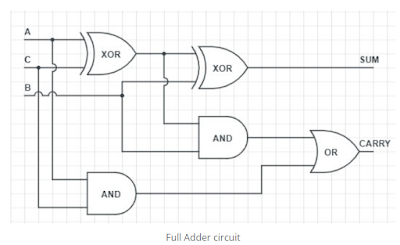

Where:
* A = x_n
* C = y_n
* B = Carry_n
* SUM = y_n
* CARRY = Carry_n+1

In [12]:
faulty = set()

In [13]:
# Finding the ones that outputs z_x from something else than XOR
for op in operations:
    if op.destination == "z45": # Ignore the last one as it's special
        continue
    if op.destination.startswith("z"):
        if op.operation.__name__ != "op_xor":
            faulty.add(op.destination)

In [14]:
# Finding the destinatinos that outputs from a XOR and is not from the first one
between_xors = []
all_xor_outputs = []
for op in operations:
    if op.operation.__name__ != "op_xor":
        continue
    all_xor_outputs.append(op.destination)
    if op.destination.startswith("z"):
        continue
    if op.first[0] in ["x", "y"] and op.second[0] in ["x", "y"]:
        between_xors.append(op.destination)

for output in all_xor_outputs:
    if output in between_xors:
        continue
    if output.startswith("z"):
        continue
    faulty.add(output)

In [15]:
# Find the ones that output from an OR but not inputting to XOR (the next adder)
for op1 in operations:
    if op1.operation.__name__ != "op_xor":
        continue
    for op2 in operations:
        if op2.operation.__name__ != "op_or":
            continue
        if op2.first == op1.destination or op2.second == op1.destination:
            faulty.add(op1.destination)

In [16]:
# Find the ones that output an invalid carry output (from the OR feeding to AND or XOR)
for op1 in operations:
    if op1.first == "x00":
        continue
    if op1.operation.__name__ != "op_and":
        continue
    for op2 in operations:
        if op2.operation.__name__ == "op_or":
            continue
        if op2.first == op1.destination or op2.second == op1.destination:
            faulty.add(op1.destination)

In [17]:
part2 = ",".join(sorted(list(faulty)))
print(f"Answer #2: {part2}")

Answer #2: dwp,ffj,gjh,jdr,kfm,z08,z22,z31
